## Analyzing a random sequence

In this notebook, we will implement and query the following probabilistic model of a random sequence in SPPL.
1. For $i = 0$, $X[0]$ is a standard normal.
2. For $i > 0$
 - if $X[i-1]$ is negative, then $X[i]$ is a standard normal
 - otherwise, let $W[i]$ be the outcome of a fair coin:
    - if $W[i] = 0$, then $X[i] = 0.5*(X[i-1])^2 + X[i-1]$
    - othewrise, $X[i]$ is a standard normal.

In [1]:
%load_ext sppl.magics

**Defining the model in SPPL.**

In [2]:
%%sppl random_sequence
from fractions import Fraction

X = array(3)
W = array(3)

X[0] ~= norm()
for i in range(1, 3):
    if X[i-1] > 0:
        X[i] ~= norm(loc=0, scale=1)
        W[i] ~= atomic(loc=0)
    else:
        W[i] ~= bernoulli(p=0.5)
        if W[i] == 0:
            X[i] ~= Fraction(1,2)*X[i-1]**2 + X[i-1]
        else:
            X[i] ~= norm(loc=0, scale=1)

**SPML programs are represented as sum-product expressions.<br/>
We can view the SPE that corresponds to the `random_sequence` model.**

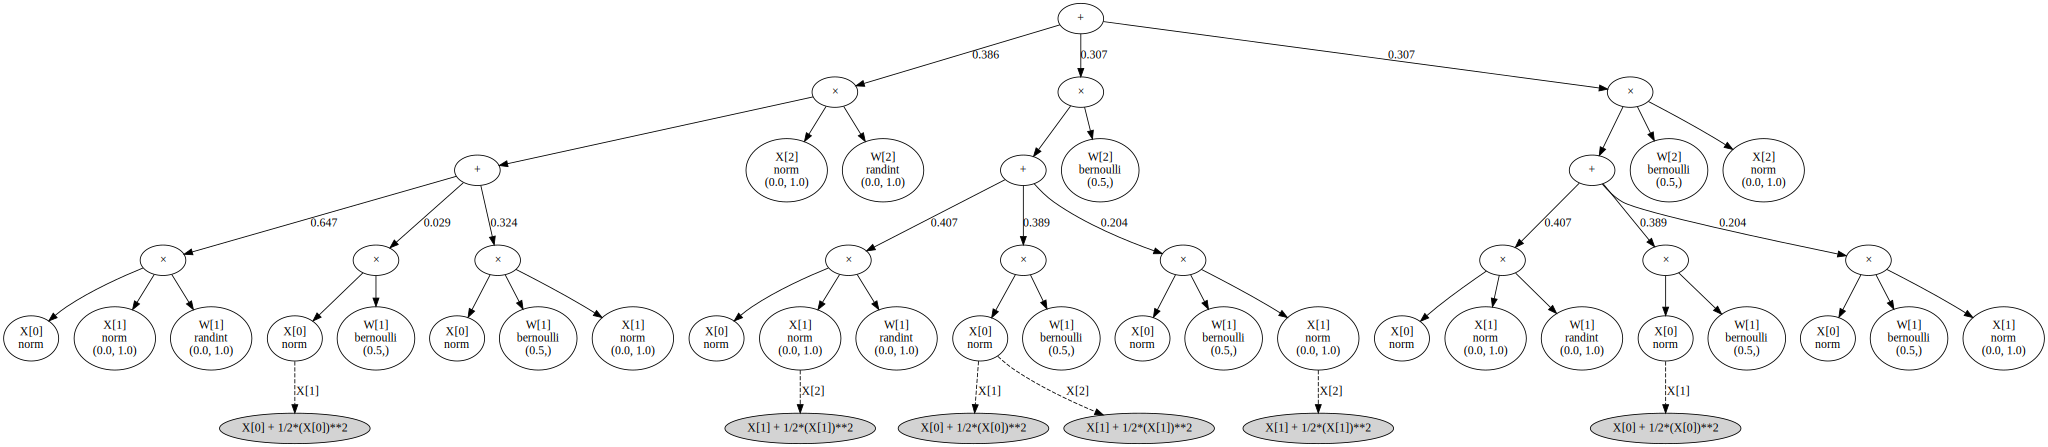

In [3]:
%sppl_to_graph random_sequence

It is informative to consider the distribution encoded by the graphical structure above.

1. `+` (sum) nodes indicate a probabilistic mixture model over its children, with weights along the edges.
2. `x` (proudct) nodes indicate that the children are independent.
3. Leaf nodes indicate names and distributions of the base random variables in the model.
 - Dashed edges and shaded nodes indicate deterministic transforms of random variables, with the symbol shown along the edge and the expression shown in the node label.

**Executing the model returns a namespace `ns` that contains all the variables in the model.**

In [4]:
ns = %sppl_get_namespace random_sequence
random_sequence = ns.random_sequence

**Suppose we observe that X[1] > 0.<br/>
What is the posterior probability that X[0] > 0?**

We can use `condition` and `logprob` queries from **SPQL** to answer this question.

In [5]:
# Condition `random_sequence` on the observation X[1] > 0.
random_sequence_given_X1 = random_sequence.condition(ns.X[1] > 0)

# Print the prior and posterior probabilities of X[0] > 0.
print('Pr(X[0]>0)\t\t= %1.2f' % (random_sequence.prob(ns.X[0]>0),))
print('Pr(X[0]>0 | X[1]>0)\t= %1.3f' % (random_sequence_given_X1.prob(ns.X[0]>0),))

Pr(X[0]>0)		= 0.50
Pr(X[0]>0 | X[1]>0)	= 0.647


**Suppose we observe that X[2] > 0.<br/>
What is the posterior probability that X[0] > 0?**

We can use `condition` and `logprob` queries from **SPQL** to answer this question.

In [6]:
# Condition `random_sequence` on the observation X[2] > 0.
random_sequence_given_X2 = random_sequence.condition(ns.X[2] > 0)

# Print the prior and posterior probabilities of X[0] > 0.
print('Pr(X[0]>0)\t\t= %1.2f' % (random_sequence.prob(ns.X[0]>0),))
print('Pr(X[0]>0 | X[2]>0)\t= %1.3f' % (random_sequence_given_X2.prob(ns.X[0]>0),))

Pr(X[0]>0)		= 0.50
Pr(X[0]>0 | X[2]>0)	= 0.544


**Notice that observing (X[1]>0) shifts the probability of (X[0]>0) from 0.5 to 0.647,<br/>
whereas observing (X[2]>0) shifts the probability of (X[0]>0) from 0.5 to 0.544.**

Intuitively, X[1] contains 'more information' about X[0] as compared to X[2], since X[2] occurs later in the randoms sequence.<br/>
We can use `mutual_infomration` to make this intuition quantitative.<br/><br/>
The observation X[1]>0 has 10x more information about X[0]>0 as compared to the observation X[2]>0.

In [7]:
print('MI(X[0]>0 : X[1]>0)\t= %1.3f' % (random_sequence.mutual_information(ns.X[0]>0, ns.X[1]>0),))
print('MI(X[0]>0 : X[2]>0)\t= %1.3f' % (random_sequence.mutual_information(ns.X[0]>0, ns.X[2]>0),))

MI(X[0]>0 : X[1]>0)	= 0.028
MI(X[0]>0 : X[2]>0)	= 0.002


**Note that the output of `random_sequence.condition(X[1] > 0)` is just another SPE.**

Look how much smaller the conditioned SPE is!<br/>
In effect, we have analytically (symbolically) eliminated all the exections of `random_sequence` where X[1] < 0.

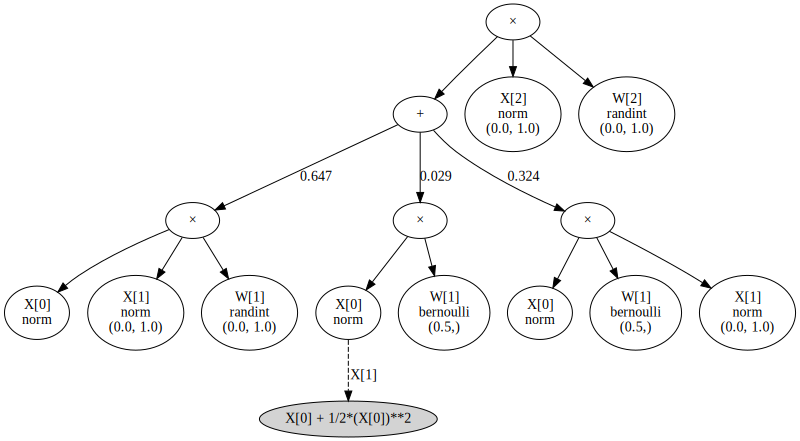

In [8]:
%sppl_to_graph random_sequence_given_X1

**Similarly, the output of `random_sequence.condition(X[2] > 0)` is also another SPE.**

In this case the SPE has the same structure, but the numeric probabiliites on the edges have changed.<br/>
In general `.condition` can grow or shrink the underlying SPE, depending on the complexity of the query and SPE.

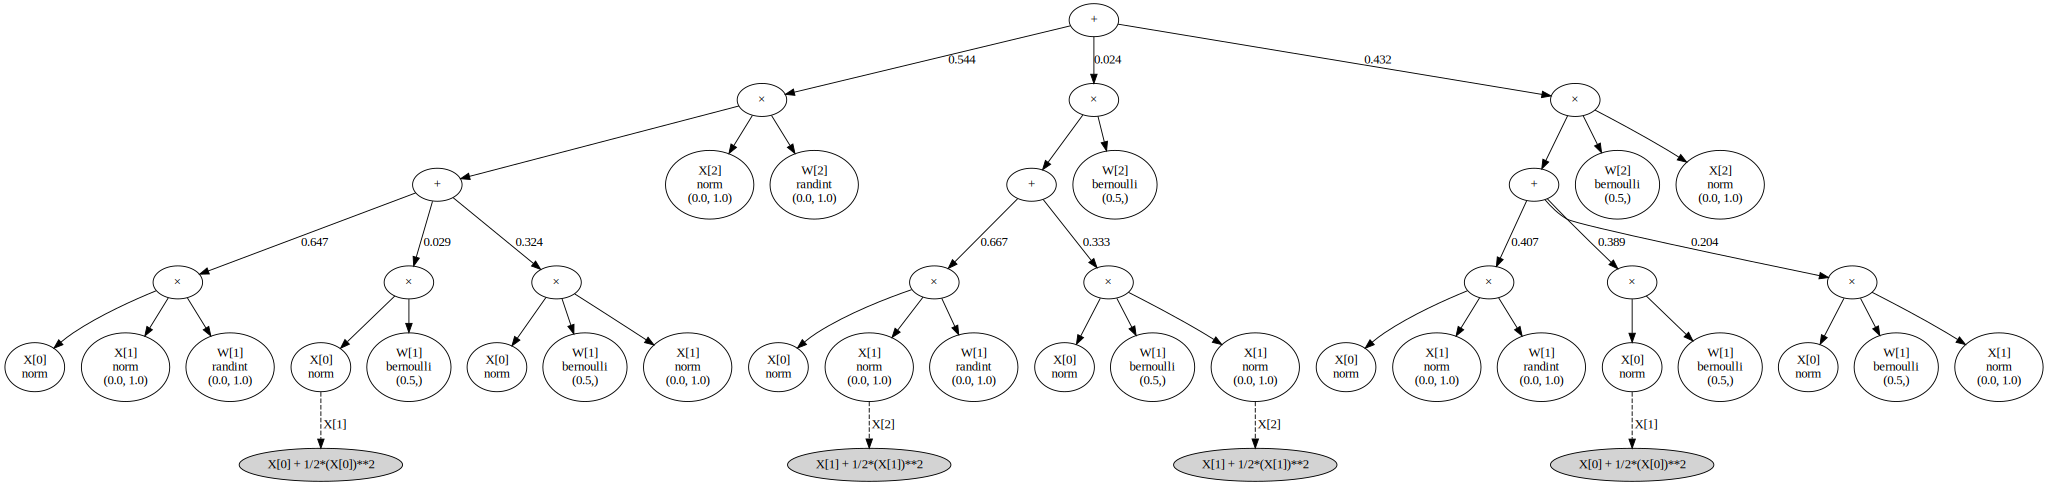

In [9]:
%sppl_to_graph random_sequence_given_X2